# Required Actions

## Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libraries

In [ ]:
import numpy as np
import os
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import librosa
from librosa import display
from IPython.display import Audio
from tensorflow import keras


# Single Example Trial

Try different methods of processing and different models *on* a single example from dataset.

## Preprocessing

In [ ]:
file_path1 = "/content/drive/MyDrive/Final Year Project/Voice data/Normal/1-phrase.wav"
samples1, sampling_rate = librosa.load(file_path1, sr = None, mono = True, offset = 0.0, duration = None)
file_path2 = "/content/drive/MyDrive/Final Year Project/Voice data/Pathological/1193-phrase.wav"
samples2, sampling_rate = librosa.load(file_path2, sr = None, mono = True, offset = 0.0, duration = None)
# samples1.shape[0], samples2[:samples1.shape[0]].shape
if samples1.shape[0] < 100000:
  samples1 = np.pad(samples1, (0, 100000 - samples1.shape[0]))
else:
  samples1 = samples1[:100000]
if samples2.shape[0] < 100000:
  samples2 = np.pad(samples2, (0, 100000 - samples2.shape[0]))
else:
  samples2 = samples2[:100000]
D1 = librosa.stft(samples1)
S_db1 = librosa.amplitude_to_db(np.abs(D1), ref=np.max)
D2 = librosa.stft(samples2)
S_db2 = librosa.amplitude_to_db(np.abs(D2), ref=np.max)
# S_db.shape

In [ ]:
samples1[:20]

array([0.00057983, 0.0012207 , 0.00128174, 0.00134277, 0.00137329,
       0.00094604, 0.00115967, 0.0012207 , 0.0010376 , 0.00097656,
       0.00119019, 0.00073242, 0.0005188 , 0.00064087, 0.00048828,
       0.00027466, 0.        , 0.00027466, 0.00079346, 0.00091553],
      dtype=float32)

In [ ]:
from IPython.display import Audio
Audio(file_path)

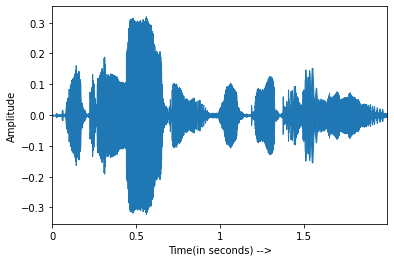

In [ ]:
from librosa import display
plt.figure()
librosa.display.waveplot(y = samples1, sr = sampling_rate)
plt.xlabel("Time(in seconds) -->")
plt.ylabel("Amplitude")
plt.show()

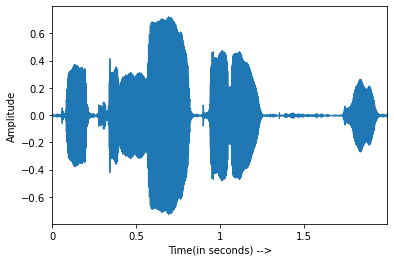

In [ ]:
from librosa import display
plt.figure()
librosa.display.waveplot(y = samples2, sr = sampling_rate)
plt.xlabel("Time(in seconds) -->")
plt.ylabel("Amplitude")
plt.show()

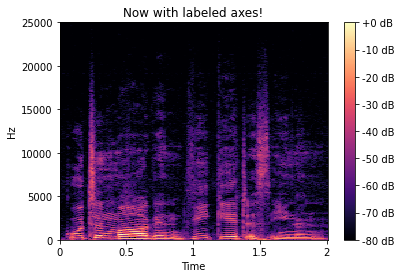

In [ ]:
# D = librosa.stft(samples)
# S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(S_db1, sr=sampling_rate, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Now with labeled axes!')
fig.colorbar(img, ax=ax, format="%+2.f dB")
# S_db = np.expand_dims(S_db, axis = (0, 3))
# S_db.shape
# samples.shape

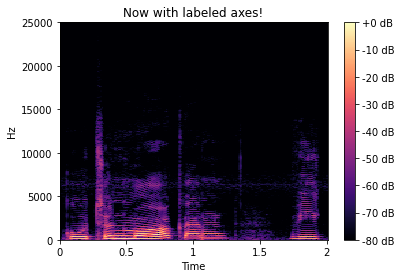

In [ ]:
fig, ax = plt.subplots()
img = librosa.display.specshow(S_db2, sr=sampling_rate, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Now with labeled axes!')
fig.colorbar(img, ax=ax, format="%+2.f dB")

## Deep Learning Models

In [ ]:
from tensorflow import keras

sample_model = keras.Sequential([
    keras.layers.Conv2D(32, 3, activation='relu', input_shape=S_db.shape[1:]),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(64, 3, activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])
sample_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 1023, 197, 32)     320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 511, 98, 32)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 509, 96, 64)       18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 254, 48, 64)       0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 780288)            0         
_________________________________________________________________
dense_48 (Dense)             (None, 512)               399507968 
_________________________________________________________________
dense_49 (Dense)             (None, 256)             

In [ ]:
sample_model.compile(optimizer='sgd', loss='mse')
sample_model.fit(S_db, np.ones((1,)), batch_size=1, epochs=2)

Epoch 1/2
1/1 [==============================] - 2s 2s/step - loss: 0.5000
Epoch 2/2
1/1 [==============================] - 1s 1s/step - loss: 0.5000


In [ ]:
file_path = "/content/drive/MyDrive/Final Year Project/Voice data/Pathological/1193-phrase.wav"
samples, sampling_rate = librosa.load(file_path, sr = None, mono = True, offset = 0.0, duration = None)
print(len(samples), sampling_rate)
D = librosa.stft(samples)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_db = np.expand_dims(S_db, axis=(0,3))
print(S_db.shape)
# predictions = sample_model.predict(S_db)
# predictions

164529 50000
(1, 1025, 322, 1)


# Full Dataset Processing

Process all examples within the given dataset, and train and compare final models.

## 1. Load Data
[Get list of all audio recordings.](https://www.geeksforgeeks.org/python-list-files-in-a-directory/)

[Pad or cut recording size to get same sized samples.](https://librosa.org/doc/0.7.0/generated/librosa.core.load.html)

[Add positive and negative labels for corresponding audio recordings from the different folders.](geeksforgeeks.org/python-pandas-dataframe/)

In [ ]:
base_path = "/content/drive/MyDrive/Final Year Project/Voice data"
all_folders = os.listdir(base_path)
all_folders

['Normal', 'Pathological']

In [ ]:
def load_audio_file(folder_path, file_name):
  file_path = os.path.join(folder_path, file_name)
  audio_samples, sampling_rate = librosa.load(file_path, sr = 50000, mono = True, offset = 0.0, duration = 2)
  
  # Max samples size = 100000 for duration = 2 seconds.
  if audio_samples.shape[0] < 100000:
    audio_samples = np.pad(audio_samples, (0, 100000 - audio_samples.shape[0]))
  else:
    audio_samples = audio_samples[:100000]

  return audio_samples

## 2. Preprocess Data
[Perform Fourier Transform on all individual recordings.](http://librosa.org/doc/main/generated/librosa.stft.html)

[Expand dimensions of all recordings and concatenate.](https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html)

In [ ]:
def transform_audio(audio_data):
  transformed_audio = librosa.stft(audio_data)
  transformed_audio = librosa.amplitude_to_db(np.abs(transformed_audio), ref = np.max)
  return transformed_audio

In [ ]:
def load_and_process_all_data(base_path, folders_list):
  labels = np.zeros((1))
  data = np.empty((1, 1025, 196, 1))

  for folder_name in folders_list:
    folder_path = os.path.join(base_path, folder_name)
    files_list = os.listdir(folder_path)

    for file_name in files_list:

      if folder_name == 'Normal':
        labels = np.append(labels, 0)
      else:
        labels = np.append(labels, 1)

      audio_file = load_audio_file(folder_path, file_name)
      transformed_audio = transform_audio(audio_file)
      transformed_audio = np.expand_dims(transformed_audio, axis=(0, 3))
      data = np.concatenate((data, transformed_audio), axis = 0)
      
  return data[1:, :, :, :], labels[1:]

In [ ]:
data, labels = load_and_process_all_data(base_path, all_folders)
data.shape, labels.shape

((236, 1025, 196, 1), (236,))

## 3. Deep Learning Models
[Convolutional Neural Networks to be used.](https://d2l.ai/chapter_convolutional-neural-networks/index.html)